In [1]:
!pip install conllu


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from conllu import parse_tree

In [3]:
language = "UD_Spanish-GSD"
file_name = "es_gsd-ud-train"

conllu_file = f"../data/deep/{language}/{file_name}.conllu"

with open(conllu_file, 'r', encoding='utf-8') as file:
        data = file.read()
    
sentences = parse_tree(data)

token = sentences[0]

In [3]:
token.print_tree()

(deprel:root) form:pediría lemma:pedir upos:VERB [4]
    (deprel:advmod) form:Además lemma:además upos:ADV [1]
    (deprel:iobj) form:se lemma:él upos:PRON [2]
    (deprel:iobj) form:le lemma:él upos:PRON [3]
    (deprel:iobj) form:empresas lemma:empresa upos:NOUN [7]
        (deprel:case) form:a lemma:a upos:ADP [5]
        (deprel:det) form:las lemma:el upos:DET [6]
        (deprel:amod) form:interesadas lemma:interesado upos:ADJ [8]
            (deprel:advcl) form:prestar lemma:prestar upos:VERB [10]
                (deprel:mark) form:en lemma:en upos:ADP [9]
                (deprel:obj) form:servicio lemma:servicio upos:NOUN [12]
                    (deprel:det) form:el lemma:el upos:DET [11]
    (deprel:csubj) form:hagan lemma:hacer upos:VERB [15]
        (deprel:mark) form:que lemma:que upos:SCONJ [13]
        (deprel:iobj) form:se lemma:él upos:PRON [14]
        (deprel:obj) form:cargo lemma:cargo upos:NOUN [16]
            (deprel:nmod) form:señalización lemma:señalización upos

In [86]:
token.token["form"]

'pediría'

In [87]:
token.children

[TokenTree<token={id=1, form=Además}, children=None>,
 TokenTree<token={id=2, form=se}, children=None>,
 TokenTree<token={id=3, form=le}, children=None>,
 TokenTree<token={id=7, form=empresas}, children=[...]>,
 TokenTree<token={id=15, form=hagan}, children=[...]>,
 TokenTree<token={id=29, form=.}, children=None>]

In [10]:
import networkx as nx


def add_edges(graph, nodo):
    children = nodo.children
    if children!=[]:
        for hijo in nodo.children:
            graph.add_node(hijo.token["id"], form=hijo.token["form"])
            graph.add_edge(nodo.token["id"], hijo.token["id"])
            
    return list(children)
 

def get_tree(root):
    graph = nx.DiGraph()
    actual_node = root
    graph.graph["phrase"] = actual_node.metadata["text"]
    graph.graph["root"] = actual_node.token["id"]
    nodes = root.children
    while nodes!=[]:
        graph.add_node(actual_node.token["id"], form=actual_node.token["form"])
        nodes = nodes + add_edges(graph=graph, nodo=actual_node)
        actual_node = nodes.pop(0)
    
    return graph
        

for i, sentence in enumerate(sentences):
    root = sentence
    graph = get_tree(root)
    nx.write_graphml(graph, f"../data/graphs/{language}/{file_name}_{i}.graphml")

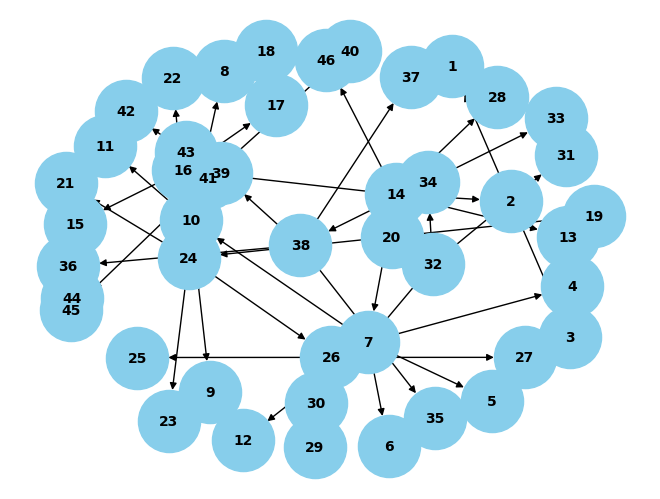

In [7]:
nx.draw(graph, with_labels=True, node_size=2000, node_color="skyblue", font_size=10, font_weight="bold")

In [6]:
nx.is_weakly_connected(graph)

True

In [8]:
print(token.metadata["text"])

Además se le pediría a las empresas interesadas en prestar el servicio que se hagan cargo de la señalización y la cartelería que contiene información para los usuarios.


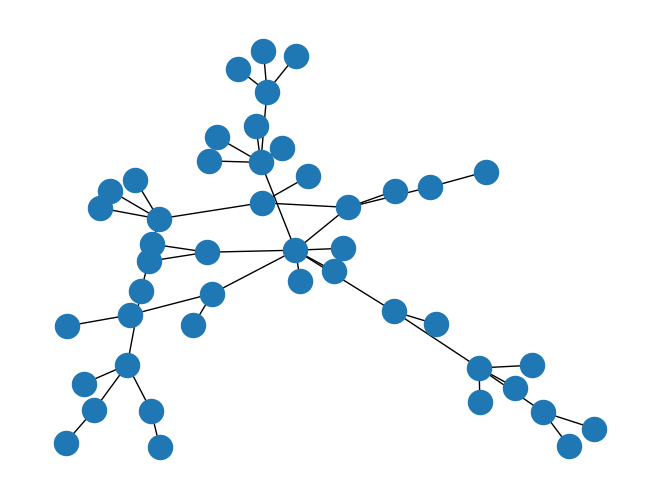

In [7]:
nx.draw(graph.to_undirected())

In [9]:
nx.is_tree(graph.to_undirected())

True

In [130]:
!pip install networkx==2.2

  Using cached networkx-2.2-py2.py3-none-any.whl
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-timeseries 1.1.0 requires networkx<4,>=3.0, but you have networkx 2.2 which is incompatible.
node2vec 0.4.6 requires networkx<3.0,>=2.5, but you have networkx 2.2 which is incompatible.
visions 0.7.6 requires networkx>=2.4, but you have networkx 2.2 which is incompatible.
scikit-image 0.20.0 requires networkx>=2.8, but you have networkx 2.2 which is incompatible.
grandiso 2.2.0 requires networkx>=2.5.1, but you have networkx 2.2 which is incompatible.
autogluon-core 1.1.0 requires networkx<4,>=3.0, but you have networkx 2.2 which is incompatible.
dotmotif 0.14.0 requires networkx<4.0,>=3.1, but you 

In [131]:
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1


In [139]:
!pip install --upgrade networkx

  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
  Attempting uninstall: networkx
    Found existing installation: networkx 2.2
    Uninstalling networkx-2.2:
      Successfully uninstalled networkx-2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
node2vec 0.4.6 requires networkx<3.0,>=2.5, but you have networkx 3.4.2 which is incompatible.
